In [1]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import keras

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn as sks

2025-10-04 12:40:37.596298: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-04 12:40:37.597710: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-04 12:40:37.601415: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-04 12:40:37.610895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759606837.631014    8313 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759606837.63

## Load the Dataset

Load the moons dataset from [scikit-learn](https://scikit-learn.org/stable/).

In [8]:
X, y = sks.datasets.make_moons(n_samples=200, noise=0.2, random_state=42)

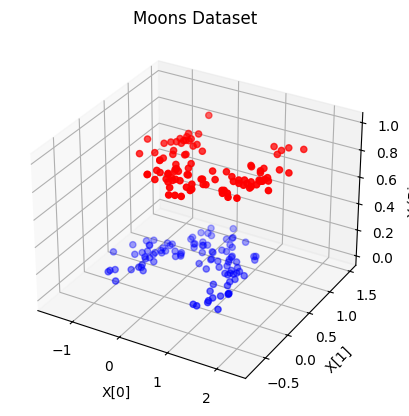

In [9]:
colors = np.where(y == 1, 'red', 'blue') # Assign 'red' for y=1, 'blue' for y=0

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],y, c=colors)
ax.set_xlabel('X[0]')
ax.set_ylabel('X[1] ')
ax.set_zlabel('Y (Binary)')
ax.set_title('Moons Dataset')
plt.show()

## The Variational Circuit

### Defining Circuit Parameters

The variational circuit is defined based on 2 parameters:
* The number of layers ($l$)
* The number of input variables or qubits ($q$)

In [117]:
layers = 5
qubits = X.shape[-1]

We create the weight matrix based on the parameters described earlier. Each layer is applied per qubit, and each qubit needs 3 parameters for the `qml.Rot` gate. Therefore we get a weight matrix of the shape $(l,q,3)$. 

`np.random.rand` creates random values $\in [0,1)$, however we want the periodic range of our rotational gates, therefore we multiply the weights by $2\pi$.

In [118]:
w = np.random.rand(layers,qubits,3)*2*np.pi
print(w.shape)

(5, 2, 3)


The weights are wrapped into a tensorflow variable for training

In [119]:
weights = tf.Variable(w)
print(weights.shape)

(5, 2, 3)


We can now define our pennylane device based on the number of qubits. We use the `lightning.qubit` backend for better performance.

### Creating the Circuit

In [120]:
dev = qml.device('lightning.qubit',wires=qubits)

We now create the actual circuit based on the parameters. Keep in mind the following points:
1. The `qml.qnode` decorator is important for the circuit to be runnable in pennylane
2. The `interface` argument of the qnode should match the library used
3. The order of input arguments is **important** as pennylane always assumes the last argument to be the data for batching reasons

In [121]:
@qml.qnode(dev,interface='tf') # Define the pennylane qnode wrapper
def variational_model(weights,x): 
    flipper = True
    for q in range(weights.shape[1]):
        qml.RY(x[:,q],wires=q)
    for w in weights:
        for q in range(w.shape[0]):
            qml.Rot(*w[q],wires=q)
        if(flipper):
            qml.CNOT([0,1])
        else:
            qml.CNOT([1,0])
        flipper = not flipper
    return qml.probs(0) ## Measure the probability of the first qubit as logits

We can visualize the circuit below

(<Figure size 1400x300 with 1 Axes>, <Axes: >)

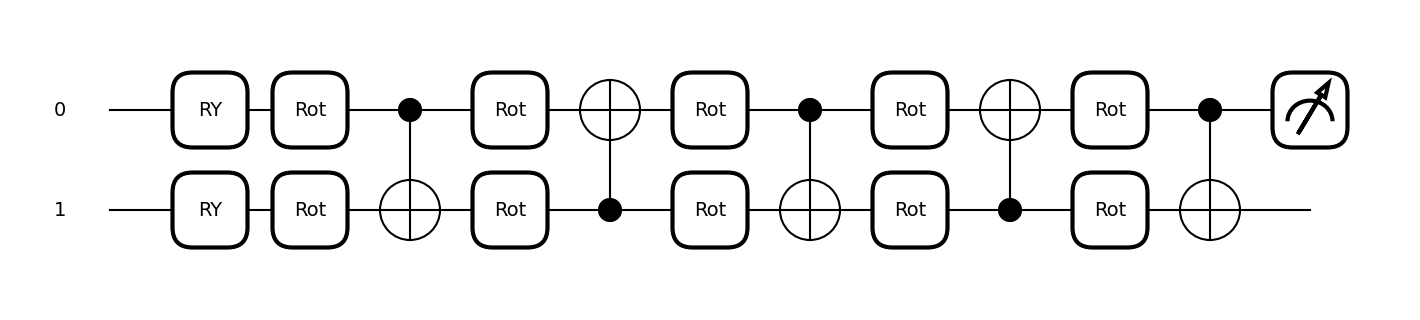

In [122]:
qml.draw_mpl(variational_model)(weights,X[:2])

Let's plot what the predictions from our randomly initialized model look like. In order to make a prediction, we need a **threshold value**. Here we use a threshold value of $t=0.5$.

In [123]:
t = 0.5
random_preds = variational_model(weights,X) 

As we can see below, the model returns both the $\ket{0}$ and $\ket{1}$ probabilities. However, as they sum to 1, the $\ket{1}$ probabilities are redundant and can be discarded. Therefore, the higher probability of measuring  $\ket{0}$ in our model corresponds to the '1'-label of the moons dataset.   

In [124]:
print(random_preds[:2])

tf.Tensor(
[[0.72128525 0.27871475]
 [0.7158926  0.2841074 ]], shape=(2, 2), dtype=float64)


In [125]:
random_preds = random_preds[:,0]

Now we apply the thresholding. We create a booleans using the `>=` operators. When the booleans are converted to floating point numbers 'False'$\rightarrow 0$ and 'True'$\rightarrow 1$.

In [126]:
labels = tf.cast(random_preds>=t,tf.uint8)

We can use the same plotting function as before

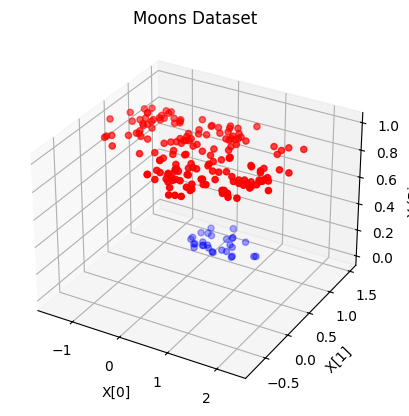

In [127]:
colors = np.where(labels == 1, 'red', 'blue') # Assign 'red' for y=1, 'blue' for y=0

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],labels, c=colors)
ax.set_xlabel('X[0]')
ax.set_ylabel('X[1] ')
ax.set_zlabel('Y (Binary)')
ax.set_title('Moons Dataset')
plt.show()

As we can see, this does not match our dataset very well at all.

## Training the model
The model is trained using the tensorflow framework and its [`GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) for automatic differentiation. However, tensorflow uses Keras for a lot of the high level components such as optimizers. 

We first define our optimizer, and loss functions.

In [128]:
lossfn = keras.losses.binary_crossentropy
opt = keras.optimizers.Adam(learning_rate=0.03)

Now we can define a training loop. This is just the forward pass or the process of passing data through our model and comparing the outputs. For this, we need to define the number of `epochs` or repetitions of the entire process. For now let's train for 50 epochs. 

In [129]:
epochs = 50

Lets first code out a single training step to see how everthing works. We can loop over it for epochs later. There are 4 main components to the training step:
1. **Gradient Tape Set-Up**: The inference and loss computation need to be enclosed in a gradient tape and the tape needs to be told to watch the `weights` variable in order to compute gradients.
2. **Model Inference**: The model is used to perform inference on the entire dataset to get $\ket{0}$ probabilities to be used with the loss function
3. **Loss Computation**: The true values from our dataset are used to compute binary crossentropy loss for the predicted labels.
4. **Gradient and Optimization**: The gradients are computed for the loss with respect to the weights. These are used to update the weights via the optimizer's `apply_gradients` method.

In [130]:
# Gradient Tape Set up
with tf.GradientTape() as tape:
    tape.watch(weights)
    # Model Inference
    y_pred = variational_model(weights,X)[:,0]
    # Loss Computation
    loss = lossfn(y,y_pred)
print(loss)
# Gradient and Optimization
grads = tape.gradient(loss,weights)
opt.apply_gradients(zip([grads],[weights]))

tf.Tensor(0.5889451966830763, shape=(), dtype=float64)


<KerasVariable shape=(), dtype=int64, path=adam/iteration>

Now we can just loop an `epochs` number of times through the train step and see the loss reducing.

In [ ]:
for epoch in range(epochs):
    # Gradient Tape Set up
    with tf.GradientTape() as tape:
        tape.watch(weights)
        # Model Inference
        y_pred = variational_model(weights,X)[:,0]
        # Loss Computation
        loss = lossfn(y,y_pred)
    # Gradient and Optimization
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip([grads],[weights]))
    if(epoch%5==0): # Print loss every 5 epochs
        print(f"Loss at epoch {epoch} = {loss.numpy(): .3f}")

Loss at epoch 0 =  0.505
Loss at epoch 5 =  0.422
Loss at epoch 10 =  0.405


### Plotting Results
We can use the same plotting method as before to see our predicted labels. We also plot the true labels on top of the predicted labels to see how well it matches. ?

In [ ]:
trained_preds = variational_model(weights,X)[:,0]
labels = tf.cast(trained_preds>=t,tf.uint8)

In [ ]:
colors = np.where(labels == 1, 'red', 'blue') # Assign 'red' for y=1, 'blue' for y=0
true_colors = np.where(y == 1, 'green', 'purple') # Assign 'red' for y=1, 'blue' for y=0

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],labels, c=colors)
ax.scatter(X[:,0],X[:,1],y, c=true_colors, marker='x',alpha=0.5)
ax.set_xlabel('X[0]')
ax.set_ylabel('X[1] ')
ax.set_zlabel('Y (Binary)')
ax.set_title('Moons Dataset')
plt.show()